# Imports

In [1]:
import numpy as np
import torch
import os
from matplotlib import pyplot as plt

from utils.image_helpers import plot_image_grid, get_images
from simulation.Simulation import Simulation
from utils.configuration_parser.gridsearch_configuration import get_gridsearch_configuration
from models.model_creation import create_model_from_parameter_combination
from fitting.Fitter import create_fitter_from_configuration
from utils.pickle_utils import save_gridsearch_result

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    os.environ['CUDA_VISIBLE_DEVICES'] = '3'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


# Load Image

In [2]:
number_of_images_used = 20

Number of Images: 10000 in data/imagenet_v2_top_images


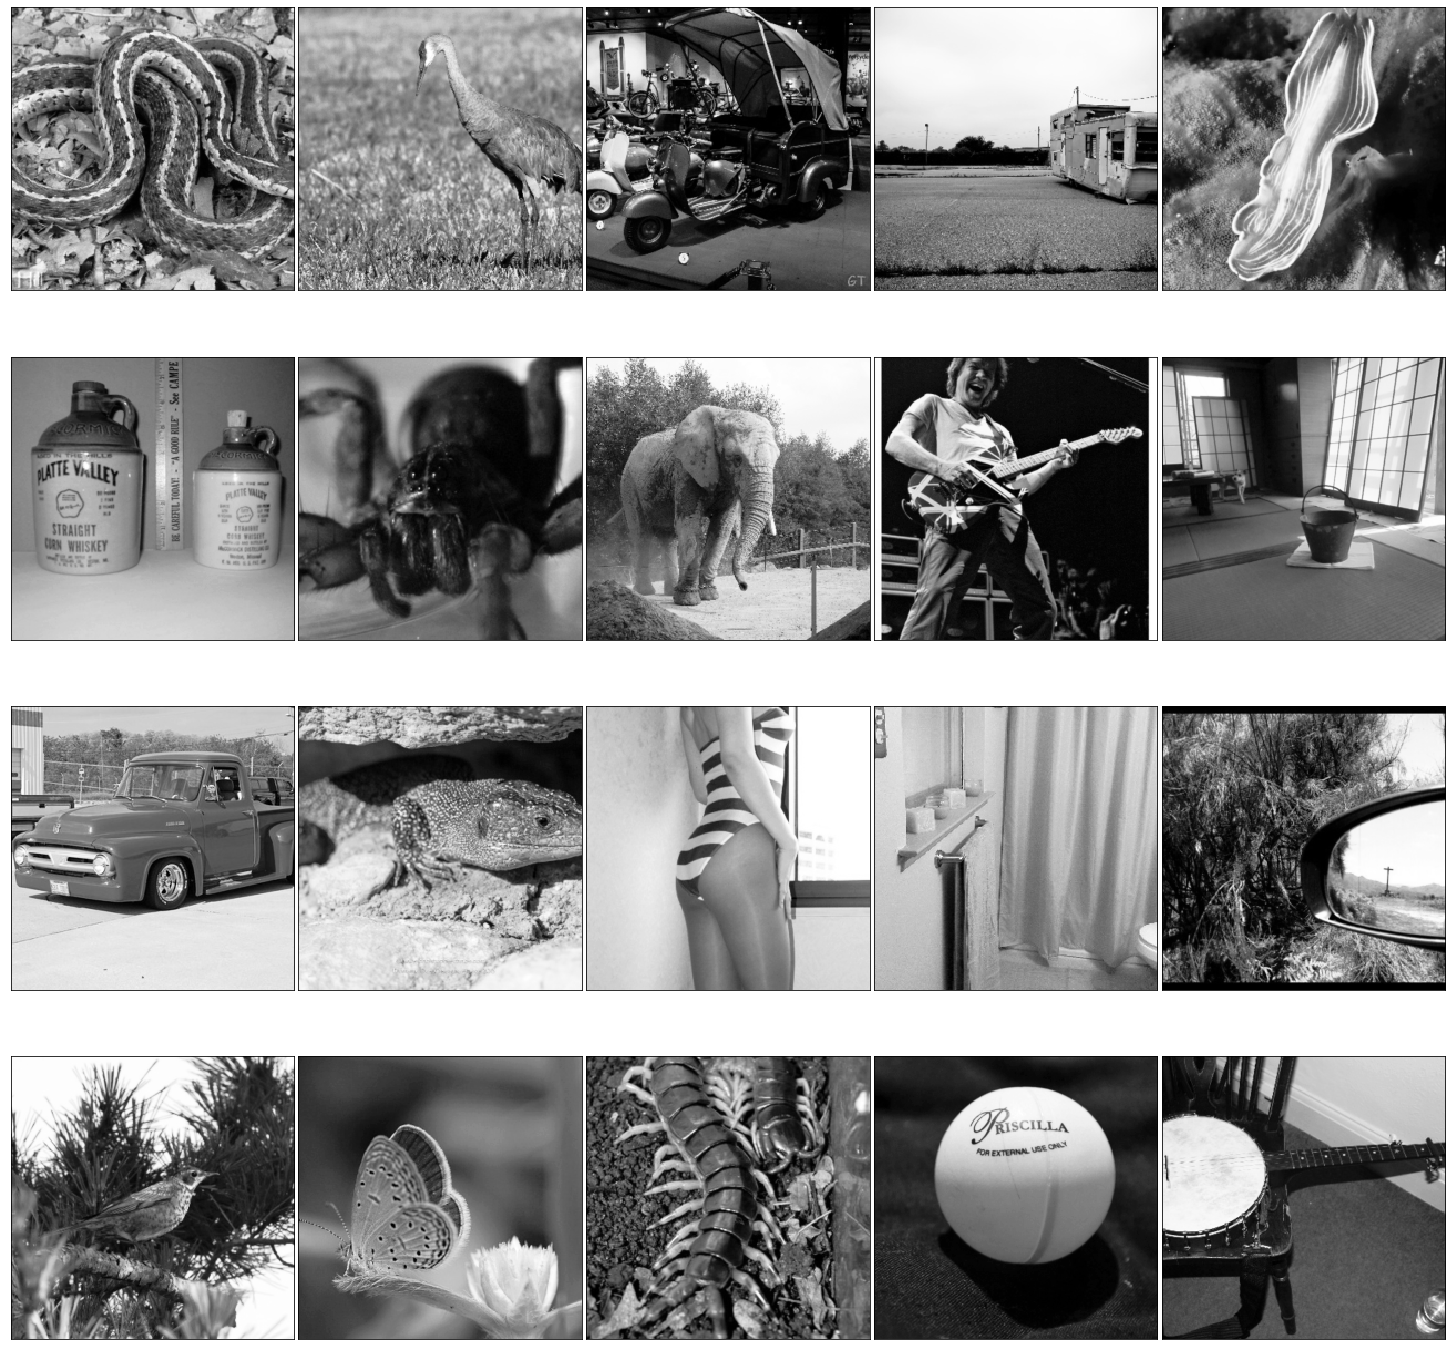

In [3]:
original_images = get_images('data/imagenet_v2_top_images', max_amount=number_of_images_used)
plot = plot_image_grid(original_images, ncols = 5)

# Gibbs Simulation

In [4]:
def scale_image(image):
    image = image - np.min(image)
    image = image/np.max(image)
    return 2 * image - 1

In [5]:
image_dimensions = original_images[0].shape
print(image_dimensions)
cropped_size = (100, 100)

(256, 256)


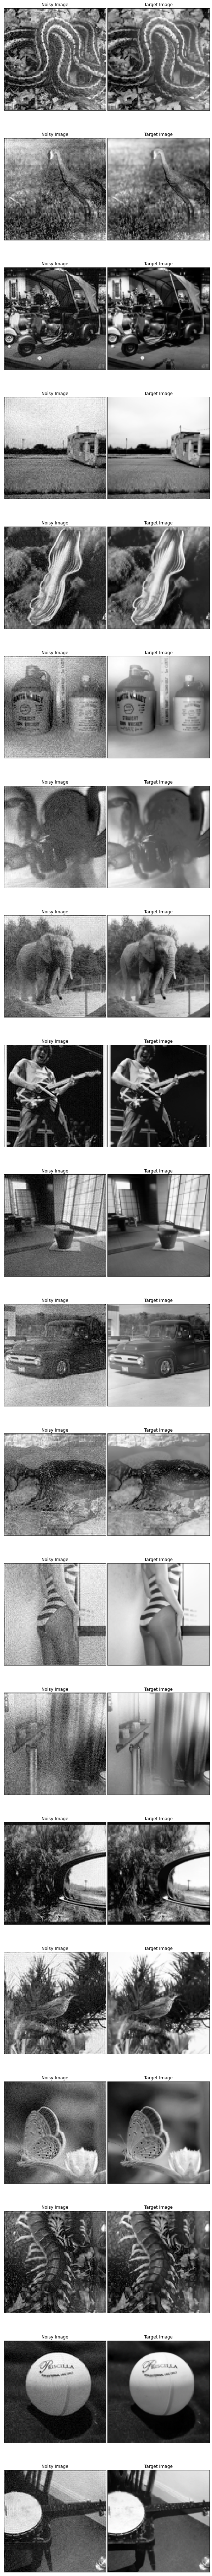

In [6]:
simulation = Simulation(input_size=image_dimensions, cropped_size=cropped_size, pf_factor=8, snr_range=(4,4), absolute_output=False)
noisy_images, target_images = simulation.simulate_list_of_images(original_images)
noisy_images = [np.concatenate((np.real(x), np.imag(x)), axis=2) for x in noisy_images]
noisy_images = [scale_image(x) for x in noisy_images]
target_images = [np.concatenate((np.real(x), np.imag(x)), axis=2) for x in target_images]
target_images = [scale_image(x) for x in target_images]

all_images = [x for row in zip(noisy_images, target_images) for x in row]
if noisy_images[0].shape[2] >=1:
    all_images = [np.linalg.norm(x, axis=2)[:, :, None] for x in all_images]
titles = ['Noisy Image', 'Target Image'] * len(noisy_images)
plot_image_grid(all_images, titles, ncols=2)
plt.show()

# Configuration

In [7]:
gridsearch_configuration = get_gridsearch_configuration()

gridsearch_configuration.model_types = ['deep']
gridsearch_configuration.input_shapes = [[4,4], [8,8], [16, 16]]
gridsearch_configuration.numbers_of_hidden_channels = [32, 64, 128]
gridsearch_configuration.numbers_of_layers = [4, 6, 8]
gridsearch_configuration.number_of_runs = 10
gridsearch_configuration.image_dimensions = list(cropped_size) + [2]

gridsearch_configuration.convergence_check_length = None
gridsearch_configuration.number_of_iterations = 2000
gridsearch_configuration.log_frequency = 100
gridsearch_configuration.save_losses = False
gridsearch_configuration.find_best = False

print(gridsearch_configuration)

image_dimensions: [100, 100, 2]  
result_path: data/results/2020-12-18-16:40-gridsearch.pkl  
model_types: ['deep']  
input_shapes: [[4, 4], [8, 8], [16, 16]]  
numbers_of_layers: [4, 6, 8]  
numbers_of_hidden_channels: [32, 64, 128]  
number_of_runs: 10  
number_of_iterations: 2000  
learning_rate: 0.1  
convergence_check_length: None  
log_frequency: 100  
find_best: False  
save_losses: False  
constant_input: False  
data_type: <class 'torch.cuda.FloatTensor'>  



In [8]:
parameter_combinations = gridsearch_configuration.generate_parameter_combinations()
# for parameters in parameter_combinations:
    # print(parameters) 

# Fit all parameter combinations and save results

In [9]:
fitter = create_fitter_from_configuration(gridsearch_configuration)

In [ ]:
 for image_index, (noisy_image, target_image) in enumerate(zip(noisy_images, target_images)):
    for parameter_index, parameter_combination in enumerate(parameter_combinations):
        print(f'Image: {image_index+1}/{len(noisy_images)}, Parameter Combination: {parameter_index+1}/{len(parameter_combinations)}')
        print('+++' + str(parameter_combination) + '+++')
        model = create_model_from_parameter_combination(parameter_combination, noisy_image.shape)
        fitter(model, noisy_image, target_image)
        result = fitter.get_result()
        save_gridsearch_result(result, gridsearch_configuration.result_path)
        print('')

Image: 1/20, Parameter Combination: 1/270
+++('deep', [4, 4], 4, 32)+++
Step: 02000, Loss: 0.059604, Target Loss: 0.077183
Image: 1/20, Parameter Combination: 2/270
+++('deep', [4, 4], 4, 64)+++
Step: 02000, Loss: 0.059757, Target Loss: 0.078018
Image: 1/20, Parameter Combination: 3/270
+++('deep', [4, 4], 4, 128)+++
Step: 02000, Loss: 0.091540, Target Loss: 0.128978
Image: 1/20, Parameter Combination: 4/270
+++('deep', [4, 4], 6, 32)+++
Step: 02000, Loss: 0.059357, Target Loss: 0.078607
Image: 1/20, Parameter Combination: 5/270
+++('deep', [4, 4], 6, 64)+++
Step: 02000, Loss: 0.059902, Target Loss: 0.078035
Image: 1/20, Parameter Combination: 6/270
+++('deep', [4, 4], 6, 128)+++
Step: 02000, Loss: 0.091540, Target Loss: 0.128978
Image: 1/20, Parameter Combination: 7/270
+++('deep', [4, 4], 8, 32)+++
Step: 02000, Loss: 0.059419, Target Loss: 0.078040
Image: 1/20, Parameter Combination: 8/270
+++('deep', [4, 4], 8, 64)+++
Step: 02000, Loss: 0.059379, Target Loss: 0.077402
Image: 1/20, P

Step: 02000, Loss: 0.059090, Target Loss: 0.076727
Image: 1/20, Parameter Combination: 67/270
+++('deep', [8, 8], 6, 32)+++
Step: 02000, Loss: 0.059129, Target Loss: 0.077627
Image: 1/20, Parameter Combination: 68/270
+++('deep', [8, 8], 6, 64)+++
Step: 02000, Loss: 0.059476, Target Loss: 0.078098
Image: 1/20, Parameter Combination: 69/270
+++('deep', [8, 8], 6, 128)+++
Step: 02000, Loss: 0.059002, Target Loss: 0.077643
Image: 1/20, Parameter Combination: 70/270
+++('deep', [8, 8], 8, 32)+++
Step: 02000, Loss: 0.091540, Target Loss: 0.128978
Image: 1/20, Parameter Combination: 71/270
+++('deep', [8, 8], 8, 64)+++
Step: 02000, Loss: 0.058955, Target Loss: 0.077186
Image: 1/20, Parameter Combination: 72/270
+++('deep', [8, 8], 8, 128)+++
Step: 02000, Loss: 0.091540, Target Loss: 0.128978
Image: 1/20, Parameter Combination: 73/270
+++('deep', [16, 16], 4, 32)+++
Step: 02000, Loss: 0.058874, Target Loss: 0.076907
Image: 1/20, Parameter Combination: 74/270
+++('deep', [16, 16], 4, 64)+++
St

Step: 02000, Loss: 0.058640, Target Loss: 0.077414
Image: 1/20, Parameter Combination: 132/270
+++('deep', [16, 16], 6, 128)+++
Step: 02000, Loss: 0.091540, Target Loss: 0.128978
Image: 1/20, Parameter Combination: 133/270
+++('deep', [16, 16], 8, 32)+++
Step: 02000, Loss: 0.058797, Target Loss: 0.077752
Image: 1/20, Parameter Combination: 134/270
+++('deep', [16, 16], 8, 64)+++
Step: 02000, Loss: 0.058680, Target Loss: 0.077120
Image: 1/20, Parameter Combination: 135/270
+++('deep', [16, 16], 8, 128)+++
Step: 02000, Loss: 0.091540, Target Loss: 0.128978
Image: 1/20, Parameter Combination: 136/270
+++('deep', [4, 4], 4, 32)+++
Step: 02000, Loss: 0.059609, Target Loss: 0.077789
Image: 1/20, Parameter Combination: 137/270
+++('deep', [4, 4], 4, 64)+++
Step: 02000, Loss: 0.059598, Target Loss: 0.077585
Image: 1/20, Parameter Combination: 138/270
+++('deep', [4, 4], 4, 128)+++
Step: 02000, Loss: 0.091540, Target Loss: 0.128978
Image: 1/20, Parameter Combination: 139/270
+++('deep', [4, 4],

Step: 02000, Loss: 0.059418, Target Loss: 0.078457
Image: 1/20, Parameter Combination: 197/270
+++('deep', [4, 4], 8, 64)+++
Step: 02000, Loss: 0.059360, Target Loss: 0.077987
Image: 1/20, Parameter Combination: 198/270
+++('deep', [4, 4], 8, 128)+++
Step: 02000, Loss: 0.091540, Target Loss: 0.128978
Image: 1/20, Parameter Combination: 199/270
+++('deep', [8, 8], 4, 32)+++
Step: 02000, Loss: 0.058957, Target Loss: 0.077214
Image: 1/20, Parameter Combination: 200/270
+++('deep', [8, 8], 4, 64)+++
Step: 02000, Loss: 0.058994, Target Loss: 0.076745
Image: 1/20, Parameter Combination: 201/270
+++('deep', [8, 8], 4, 128)+++
Step: 02000, Loss: 0.091540, Target Loss: 0.128978
Image: 1/20, Parameter Combination: 202/270
+++('deep', [8, 8], 6, 32)+++
Step: 02000, Loss: 0.059450, Target Loss: 0.075841
Image: 1/20, Parameter Combination: 203/270
+++('deep', [8, 8], 6, 64)+++
Step: 02000, Loss: 0.058849, Target Loss: 0.077642
Image: 1/20, Parameter Combination: 204/270
+++('deep', [8, 8], 6, 128)+

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Step: 02000, Loss: 0.014205, Target Loss: 0.019276
Image: 3/20, Parameter Combination: 20/270
+++('deep', [16, 16], 4, 64)+++
Step: 02000, Loss: 0.060940, Target Loss: 0.061813
Image: 3/20, Parameter Combination: 21/270
+++('deep', [16, 16], 4, 128)+++
Step: 02000, Loss: 0.060940, Target Loss: 0.061813
Image: 3/20, Parameter Combination: 22/270
+++('deep', [16, 16], 6, 32)+++
Step: 02000, Loss: 0.025197, Target Loss: 0.028364
Image: 3/20, Parameter Combination: 23/270
+++('deep', [16, 16], 6, 64)+++
Step: 02000, Loss: 0.013039, Target Loss: 0.018098
Image: 3/20, Parameter Combination: 24/270
+++('deep', [16, 16], 6, 128)+++
Step: 02000, Loss: 0.060940, Target Loss: 0.061813
Image: 3/20, Parameter Combination: 25/270
+++('deep', [16, 16], 8, 32)+++
Step: 02000, Loss: 0.013634, Target Loss: 0.018261
Image: 3/20, Parameter Combination: 26/270
+++('deep', [16, 16], 8, 64)+++
Step: 02000, Loss: 0.057223, Target Loss: 0.057783
Image: 3/20, Parameter Combination: 27/270
+++('deep', [16, 16], 

Step: 02000, Loss: 0.014944, Target Loss: 0.019053
Image: 3/20, Parameter Combination: 86/270
+++('deep', [4, 4], 6, 64)+++
Step: 02000, Loss: 0.015559, Target Loss: 0.019586
Image: 3/20, Parameter Combination: 87/270
+++('deep', [4, 4], 6, 128)+++
Step: 02000, Loss: 0.060940, Target Loss: 0.061813
Image: 3/20, Parameter Combination: 88/270
+++('deep', [4, 4], 8, 32)+++
Step: 02000, Loss: 0.015295, Target Loss: 0.019787
Image: 3/20, Parameter Combination: 89/270
+++('deep', [4, 4], 8, 64)+++
Step: 02000, Loss: 0.060940, Target Loss: 0.061813
Image: 3/20, Parameter Combination: 90/270
+++('deep', [4, 4], 8, 128)+++
Step: 02000, Loss: 0.060940, Target Loss: 0.061813
Image: 3/20, Parameter Combination: 91/270
+++('deep', [8, 8], 4, 32)+++
Step: 02000, Loss: 0.014474, Target Loss: 0.018816
Image: 3/20, Parameter Combination: 92/270
+++('deep', [8, 8], 4, 64)+++
Step: 02000, Loss: 0.013886, Target Loss: 0.018559
Image: 3/20, Parameter Combination: 93/270
+++('deep', [8, 8], 4, 128)+++
Step:

Step: 02000, Loss: 0.060940, Target Loss: 0.061813
Image: 3/20, Parameter Combination: 151/270
+++('deep', [8, 8], 8, 32)+++
Step: 02000, Loss: 0.013959, Target Loss: 0.018494
Image: 3/20, Parameter Combination: 152/270
+++('deep', [8, 8], 8, 64)+++
Step: 02000, Loss: 0.060940, Target Loss: 0.061813
Image: 3/20, Parameter Combination: 153/270
+++('deep', [8, 8], 8, 128)+++
Step: 02000, Loss: 0.060940, Target Loss: 0.061813
Image: 3/20, Parameter Combination: 154/270
+++('deep', [16, 16], 4, 32)+++
Step: 02000, Loss: 0.013885, Target Loss: 0.018635
Image: 3/20, Parameter Combination: 155/270
+++('deep', [16, 16], 4, 64)+++
Step: 02000, Loss: 0.060940, Target Loss: 0.061813
Image: 3/20, Parameter Combination: 156/270
+++('deep', [16, 16], 4, 128)+++
Step: 02000, Loss: 0.060940, Target Loss: 0.061813
Image: 3/20, Parameter Combination: 157/270
+++('deep', [16, 16], 6, 32)+++
Step: 02000, Loss: 0.013406, Target Loss: 0.018339
Image: 3/20, Parameter Combination: 158/270
+++('deep', [16, 16]

Step: 02000, Loss: 0.013102, Target Loss: 0.018103
Image: 3/20, Parameter Combination: 216/270
+++('deep', [16, 16], 8, 128)+++
Step: 02000, Loss: 0.060940, Target Loss: 0.061813
Image: 3/20, Parameter Combination: 217/270
+++('deep', [4, 4], 4, 32)+++
Step: 02000, Loss: 0.015328, Target Loss: 0.019517
Image: 3/20, Parameter Combination: 218/270
+++('deep', [4, 4], 4, 64)+++
Step: 02000, Loss: 0.015756, Target Loss: 0.019796
Image: 3/20, Parameter Combination: 219/270
+++('deep', [4, 4], 4, 128)+++
Step: 02000, Loss: 0.060940, Target Loss: 0.061813
Image: 3/20, Parameter Combination: 220/270
+++('deep', [4, 4], 6, 32)+++
Step: 02000, Loss: 0.015126, Target Loss: 0.019266
Image: 3/20, Parameter Combination: 221/270
+++('deep', [4, 4], 6, 64)+++
Step: 02000, Loss: 0.014853, Target Loss: 0.018963
Image: 3/20, Parameter Combination: 222/270
+++('deep', [4, 4], 6, 128)+++
Step: 02000, Loss: 0.060940, Target Loss: 0.061813
Image: 3/20, Parameter Combination: 223/270
+++('deep', [4, 4], 8, 32

Step: 02000, Loss: 0.125395, Target Loss: 0.157946
Image: 4/20, Parameter Combination: 11/270
+++('deep', [8, 8], 4, 64)+++
Step: 02000, Loss: 0.125318, Target Loss: 0.158781
Image: 4/20, Parameter Combination: 12/270
+++('deep', [8, 8], 4, 128)+++
Step: 02000, Loss: 0.125286, Target Loss: 0.158418
Image: 4/20, Parameter Combination: 13/270
+++('deep', [8, 8], 6, 32)+++
Step: 02000, Loss: 0.125158, Target Loss: 0.158744
Image: 4/20, Parameter Combination: 14/270
+++('deep', [8, 8], 6, 64)+++
Step: 02000, Loss: 0.125618, Target Loss: 0.159535
Image: 4/20, Parameter Combination: 15/270
+++('deep', [8, 8], 6, 128)+++
Step: 02000, Loss: 0.125665, Target Loss: 0.157544
Image: 4/20, Parameter Combination: 16/270
+++('deep', [8, 8], 8, 32)+++
Step: 02000, Loss: 0.125226, Target Loss: 0.158663
Image: 4/20, Parameter Combination: 17/270
+++('deep', [8, 8], 8, 64)+++
Step: 02000, Loss: 0.125187, Target Loss: 0.158670
Image: 4/20, Parameter Combination: 18/270
+++('deep', [8, 8], 8, 128)+++
Step:

Step: 02000, Loss: 0.125256, Target Loss: 0.158397
Image: 4/20, Parameter Combination: 77/270
+++('deep', [16, 16], 6, 64)+++
Step: 02000, Loss: 0.125100, Target Loss: 0.158574
Image: 4/20, Parameter Combination: 78/270
+++('deep', [16, 16], 6, 128)+++
Step: 02000, Loss: 0.124985, Target Loss: 0.158541
Image: 4/20, Parameter Combination: 79/270
+++('deep', [16, 16], 8, 32)+++
Step: 02000, Loss: 0.125326, Target Loss: 0.158648
Image: 4/20, Parameter Combination: 80/270
+++('deep', [16, 16], 8, 64)+++
Step: 02000, Loss: 0.125023, Target Loss: 0.158435
Image: 4/20, Parameter Combination: 81/270
+++('deep', [16, 16], 8, 128)+++
Step: 02000, Loss: 0.125142, Target Loss: 0.158975
Image: 4/20, Parameter Combination: 82/270
+++('deep', [4, 4], 4, 32)+++
Step: 02000, Loss: 0.125759, Target Loss: 0.158711
Image: 4/20, Parameter Combination: 83/270
+++('deep', [4, 4], 4, 64)+++
Step: 02000, Loss: 0.125468, Target Loss: 0.158673
Image: 4/20, Parameter Combination: 84/270
+++('deep', [4, 4], 4, 128

Step: 02000, Loss: 0.125293, Target Loss: 0.158694
Image: 4/20, Parameter Combination: 142/270
+++('deep', [4, 4], 8, 32)+++
Step: 02000, Loss: 0.125746, Target Loss: 0.159008
Image: 4/20, Parameter Combination: 143/270
+++('deep', [4, 4], 8, 64)+++
Step: 02000, Loss: 0.125483, Target Loss: 0.159644
Image: 4/20, Parameter Combination: 144/270
+++('deep', [4, 4], 8, 128)+++
Step: 02000, Loss: 0.125401, Target Loss: 0.158190
Image: 4/20, Parameter Combination: 145/270
+++('deep', [8, 8], 4, 32)+++
Step: 02000, Loss: 0.125300, Target Loss: 0.158962
Image: 4/20, Parameter Combination: 146/270
+++('deep', [8, 8], 4, 64)+++
Step: 02000, Loss: 0.125232, Target Loss: 0.158556
Image: 4/20, Parameter Combination: 147/270
+++('deep', [8, 8], 4, 128)+++
Step: 02000, Loss: 0.125317, Target Loss: 0.158508
Image: 4/20, Parameter Combination: 148/270
+++('deep', [8, 8], 6, 32)+++
Step: 02000, Loss: 0.126040, Target Loss: 0.159425
Image: 4/20, Parameter Combination: 149/270
+++('deep', [8, 8], 6, 64)++

Step: 02000, Loss: 0.125131, Target Loss: 0.158441
Image: 4/20, Parameter Combination: 207/270
+++('deep', [8, 8], 8, 128)+++
Step: 02000, Loss: 0.125131, Target Loss: 0.158439
Image: 4/20, Parameter Combination: 208/270
+++('deep', [16, 16], 4, 32)+++
Step: 02000, Loss: 0.125093, Target Loss: 0.158840
Image: 4/20, Parameter Combination: 209/270
+++('deep', [16, 16], 4, 64)+++
Step: 02000, Loss: 0.125013, Target Loss: 0.158860
Image: 4/20, Parameter Combination: 210/270
+++('deep', [16, 16], 4, 128)+++
Step: 02000, Loss: 0.125012, Target Loss: 0.158231
Image: 4/20, Parameter Combination: 211/270
+++('deep', [16, 16], 6, 32)+++
Step: 02000, Loss: 0.125233, Target Loss: 0.158831
Image: 4/20, Parameter Combination: 212/270
+++('deep', [16, 16], 6, 64)+++
Step: 02000, Loss: 0.125111, Target Loss: 0.158961
Image: 4/20, Parameter Combination: 213/270
+++('deep', [16, 16], 6, 128)+++
Step: 02000, Loss: 0.125030, Target Loss: 0.158609
Image: 4/20, Parameter Combination: 214/270
+++('deep', [16

Step: 02000, Loss: 0.069949, Target Loss: 0.077391
Image: 5/20, Parameter Combination: 2/270
+++('deep', [4, 4], 4, 64)+++
Step: 02000, Loss: 0.069940, Target Loss: 0.077390
Image: 5/20, Parameter Combination: 3/270
+++('deep', [4, 4], 4, 128)+++
Step: 02000, Loss: 0.086405, Target Loss: 0.093808
Image: 5/20, Parameter Combination: 4/270
+++('deep', [4, 4], 6, 32)+++
Step: 02000, Loss: 0.069985, Target Loss: 0.077389
Image: 5/20, Parameter Combination: 5/270
+++('deep', [4, 4], 6, 64)+++
Step: 02000, Loss: 0.069916, Target Loss: 0.077340
Image: 5/20, Parameter Combination: 6/270
+++('deep', [4, 4], 6, 128)+++
Step: 02000, Loss: 0.086405, Target Loss: 0.093808
Image: 5/20, Parameter Combination: 7/270
+++('deep', [4, 4], 8, 32)+++
Step: 02000, Loss: 0.086405, Target Loss: 0.093807
Image: 5/20, Parameter Combination: 8/270
+++('deep', [4, 4], 8, 64)+++
Step: 02000, Loss: 0.069838, Target Loss: 0.077309
Image: 5/20, Parameter Combination: 9/270
+++('deep', [4, 4], 8, 128)+++
Step: 02000, 

Step: 02000, Loss: 0.069897, Target Loss: 0.077406
Image: 5/20, Parameter Combination: 68/270
+++('deep', [8, 8], 6, 64)+++
Step: 02000, Loss: 0.069801, Target Loss: 0.077304
Image: 5/20, Parameter Combination: 69/270
+++('deep', [8, 8], 6, 128)+++
Step: 02000, Loss: 0.086405, Target Loss: 0.093808
Image: 5/20, Parameter Combination: 70/270
+++('deep', [8, 8], 8, 32)+++
Step: 02000, Loss: 0.069712, Target Loss: 0.077340
Image: 5/20, Parameter Combination: 71/270
+++('deep', [8, 8], 8, 64)+++
Step: 02000, Loss: 0.086405, Target Loss: 0.093808
Image: 5/20, Parameter Combination: 72/270
+++('deep', [8, 8], 8, 128)+++
Step: 02000, Loss: 0.086405, Target Loss: 0.093808
Image: 5/20, Parameter Combination: 73/270
+++('deep', [16, 16], 4, 32)+++
Step: 02000, Loss: 0.069676, Target Loss: 0.077356
Image: 5/20, Parameter Combination: 74/270
+++('deep', [16, 16], 4, 64)+++
Step: 02000, Loss: 0.086405, Target Loss: 0.093808
Image: 5/20, Parameter Combination: 75/270
+++('deep', [16, 16], 4, 128)+++

Step: 02000, Loss: 0.086405, Target Loss: 0.093808
Image: 5/20, Parameter Combination: 133/270
+++('deep', [16, 16], 8, 32)+++
Step: 02000, Loss: 0.069931, Target Loss: 0.077392
Image: 5/20, Parameter Combination: 134/270
+++('deep', [16, 16], 8, 64)+++
Step: 02000, Loss: 0.086405, Target Loss: 0.093808
Image: 5/20, Parameter Combination: 135/270
+++('deep', [16, 16], 8, 128)+++
Step: 02000, Loss: 0.083531, Target Loss: 0.090486
Image: 5/20, Parameter Combination: 136/270
+++('deep', [4, 4], 4, 32)+++
Step: 02000, Loss: 0.070149, Target Loss: 0.077534
Image: 5/20, Parameter Combination: 137/270
+++('deep', [4, 4], 4, 64)+++
Step: 02000, Loss: 0.086405, Target Loss: 0.093808
Image: 5/20, Parameter Combination: 138/270
+++('deep', [4, 4], 4, 128)+++
Step: 02000, Loss: 0.069847, Target Loss: 0.077287
Image: 5/20, Parameter Combination: 139/270
+++('deep', [4, 4], 6, 32)+++
Step: 02000, Loss: 0.070097, Target Loss: 0.077520
Image: 5/20, Parameter Combination: 140/270
+++('deep', [4, 4], 6,

Step: 02000, Loss: 0.086405, Target Loss: 0.093808
Image: 5/20, Parameter Combination: 198/270
+++('deep', [4, 4], 8, 128)+++
Step: 02000, Loss: 0.086405, Target Loss: 0.093808
Image: 5/20, Parameter Combination: 199/270
+++('deep', [8, 8], 4, 32)+++
Step: 02000, Loss: 0.069927, Target Loss: 0.077404
Image: 5/20, Parameter Combination: 200/270
+++('deep', [8, 8], 4, 64)+++
Step: 02000, Loss: 0.069736, Target Loss: 0.077288
Image: 5/20, Parameter Combination: 201/270
+++('deep', [8, 8], 4, 128)+++
Step: 02000, Loss: 0.086405, Target Loss: 0.093808
Image: 5/20, Parameter Combination: 202/270
+++('deep', [8, 8], 6, 32)+++
Step: 02000, Loss: 0.069776, Target Loss: 0.077296
Image: 5/20, Parameter Combination: 203/270
+++('deep', [8, 8], 6, 64)+++
Step: 02000, Loss: 0.069779, Target Loss: 0.077280
Image: 5/20, Parameter Combination: 204/270
+++('deep', [8, 8], 6, 128)+++
Step: 02000, Loss: 0.086405, Target Loss: 0.093808
Image: 5/20, Parameter Combination: 205/270
+++('deep', [8, 8], 8, 32)+

Step: 02000, Loss: 0.069785, Target Loss: 0.077360
Image: 5/20, Parameter Combination: 263/270
+++('deep', [16, 16], 4, 64)+++
Step: 02000, Loss: 0.086405, Target Loss: 0.093808
Image: 5/20, Parameter Combination: 264/270
+++('deep', [16, 16], 4, 128)+++
Step: 02000, Loss: 0.086405, Target Loss: 0.093808
Image: 5/20, Parameter Combination: 265/270
+++('deep', [16, 16], 6, 32)+++
Step: 02000, Loss: 0.069643, Target Loss: 0.077412
Image: 5/20, Parameter Combination: 266/270
+++('deep', [16, 16], 6, 64)+++
Step: 02000, Loss: 0.069639, Target Loss: 0.077310
Image: 5/20, Parameter Combination: 267/270
+++('deep', [16, 16], 6, 128)+++
Step: 02000, Loss: 0.086405, Target Loss: 0.093808
Image: 5/20, Parameter Combination: 268/270
+++('deep', [16, 16], 8, 32)+++
Step: 02000, Loss: 0.086405, Target Loss: 0.093808
Image: 5/20, Parameter Combination: 269/270
+++('deep', [16, 16], 8, 64)+++
Step: 02000, Loss: 0.086405, Target Loss: 0.093808
Image: 5/20, Parameter Combination: 270/270
+++('deep', [1

Step: 02000, Loss: 0.081479, Target Loss: 0.089596
Image: 6/20, Parameter Combination: 59/270
+++('deep', [4, 4], 6, 64)+++
Step: 02000, Loss: 0.081484, Target Loss: 0.089920
Image: 6/20, Parameter Combination: 60/270
+++('deep', [4, 4], 6, 128)+++
Step: 02000, Loss: 0.107324, Target Loss: 0.120339
Image: 6/20, Parameter Combination: 61/270
+++('deep', [4, 4], 8, 32)+++
Step: 02000, Loss: 0.079731, Target Loss: 0.086883
Image: 6/20, Parameter Combination: 62/270
+++('deep', [4, 4], 8, 64)+++
Step: 02000, Loss: 0.081473, Target Loss: 0.089800
Image: 6/20, Parameter Combination: 63/270
+++('deep', [4, 4], 8, 128)+++
Step: 02000, Loss: 0.081511, Target Loss: 0.089722
Image: 6/20, Parameter Combination: 64/270
+++('deep', [8, 8], 4, 32)+++
Step: 02000, Loss: 0.081329, Target Loss: 0.089865
Image: 6/20, Parameter Combination: 65/270
+++('deep', [8, 8], 4, 64)+++
Step: 02000, Loss: 0.081331, Target Loss: 0.089935
Image: 6/20, Parameter Combination: 66/270
+++('deep', [8, 8], 4, 128)+++
Step:

Step: 02000, Loss: 0.103765, Target Loss: 0.110185
Image: 6/20, Parameter Combination: 124/270
+++('deep', [8, 8], 8, 32)+++
Step: 02000, Loss: 0.081489, Target Loss: 0.090408
Image: 6/20, Parameter Combination: 125/270
+++('deep', [8, 8], 8, 64)+++
Step: 02000, Loss: 0.081110, Target Loss: 0.089737
Image: 6/20, Parameter Combination: 126/270
+++('deep', [8, 8], 8, 128)+++
Step: 02000, Loss: 0.081200, Target Loss: 0.090155
Image: 6/20, Parameter Combination: 127/270
+++('deep', [16, 16], 4, 32)+++
Step: 02000, Loss: 0.080894, Target Loss: 0.089676
Image: 6/20, Parameter Combination: 128/270
+++('deep', [16, 16], 4, 64)+++
Step: 02000, Loss: 0.081252, Target Loss: 0.088914
Image: 6/20, Parameter Combination: 129/270
+++('deep', [16, 16], 4, 128)+++
Step: 02000, Loss: 0.080910, Target Loss: 0.089875
Image: 6/20, Parameter Combination: 130/270
+++('deep', [16, 16], 6, 32)+++
Step: 02000, Loss: 0.081019, Target Loss: 0.089429
Image: 6/20, Parameter Combination: 131/270
+++('deep', [16, 16]

Step: 02000, Loss: 0.081329, Target Loss: 0.089882
Image: 6/20, Parameter Combination: 189/270
+++('deep', [16, 16], 8, 128)+++
Step: 02000, Loss: 0.147045, Target Loss: 0.174475
Image: 6/20, Parameter Combination: 190/270
+++('deep', [4, 4], 4, 32)+++
Step: 02000, Loss: 0.079595, Target Loss: 0.086604
Image: 6/20, Parameter Combination: 191/270
+++('deep', [4, 4], 4, 64)+++
Step: 02000, Loss: 0.081458, Target Loss: 0.089315
Image: 6/20, Parameter Combination: 192/270
+++('deep', [4, 4], 4, 128)+++
Step: 02000, Loss: 0.081656, Target Loss: 0.089128
Image: 6/20, Parameter Combination: 193/270
+++('deep', [4, 4], 6, 32)+++
Step: 02000, Loss: 0.081474, Target Loss: 0.089636
Image: 6/20, Parameter Combination: 194/270
+++('deep', [4, 4], 6, 64)+++
Step: 02000, Loss: 0.081400, Target Loss: 0.089483
Image: 6/20, Parameter Combination: 195/270
+++('deep', [4, 4], 6, 128)+++
Step: 02000, Loss: 0.081455, Target Loss: 0.090025
Image: 6/20, Parameter Combination: 196/270
+++('deep', [4, 4], 8, 32

Step: 02000, Loss: 0.081659, Target Loss: 0.089776
Image: 6/20, Parameter Combination: 254/270
+++('deep', [8, 8], 4, 64)+++
Step: 02000, Loss: 0.081319, Target Loss: 0.089339
Image: 6/20, Parameter Combination: 255/270
+++('deep', [8, 8], 4, 128)+++
Step: 02000, Loss: 0.081329, Target Loss: 0.089596
Image: 6/20, Parameter Combination: 256/270
+++('deep', [8, 8], 6, 32)+++
Step: 02000, Loss: 0.081351, Target Loss: 0.089611
Image: 6/20, Parameter Combination: 257/270
+++('deep', [8, 8], 6, 64)+++
Step: 02000, Loss: 0.081183, Target Loss: 0.089859
Image: 6/20, Parameter Combination: 258/270
+++('deep', [8, 8], 6, 128)+++
Step: 02000, Loss: 0.147045, Target Loss: 0.174475
Image: 6/20, Parameter Combination: 259/270
+++('deep', [8, 8], 8, 32)+++
Step: 02000, Loss: 0.081522, Target Loss: 0.089662
Image: 6/20, Parameter Combination: 260/270
+++('deep', [8, 8], 8, 64)+++
Step: 02000, Loss: 0.081307, Target Loss: 0.089596
Image: 6/20, Parameter Combination: 261/270
+++('deep', [8, 8], 8, 128)+

Step: 02000, Loss: 0.068401, Target Loss: 0.080135
Image: 7/20, Parameter Combination: 50/270
+++('deep', [16, 16], 6, 64)+++
Step: 02000, Loss: 0.068356, Target Loss: 0.079992
Image: 7/20, Parameter Combination: 51/270
+++('deep', [16, 16], 6, 128)+++
Step: 02000, Loss: 0.088056, Target Loss: 0.097790
Image: 7/20, Parameter Combination: 52/270
+++('deep', [16, 16], 8, 32)+++
Step: 02000, Loss: 0.087923, Target Loss: 0.097636
Image: 7/20, Parameter Combination: 53/270
+++('deep', [16, 16], 8, 64)+++
Step: 02000, Loss: 0.068546, Target Loss: 0.080291
Image: 7/20, Parameter Combination: 54/270
+++('deep', [16, 16], 8, 128)+++
Step: 02000, Loss: 0.090491, Target Loss: 0.100208
Image: 7/20, Parameter Combination: 55/270
+++('deep', [4, 4], 4, 32)+++
Step: 02000, Loss: 0.069327, Target Loss: 0.080578
Image: 7/20, Parameter Combination: 56/270
+++('deep', [4, 4], 4, 64)+++
Step: 02000, Loss: 0.075215, Target Loss: 0.086405
Image: 7/20, Parameter Combination: 57/270
+++('deep', [4, 4], 4, 128

Step: 02000, Loss: 0.093886, Target Loss: 0.103473
Image: 7/20, Parameter Combination: 115/270
+++('deep', [4, 4], 8, 32)+++
Step: 02000, Loss: 0.074770, Target Loss: 0.086066
Image: 7/20, Parameter Combination: 116/270
+++('deep', [4, 4], 8, 64)+++
Step: 02000, Loss: 0.093886, Target Loss: 0.103473
Image: 7/20, Parameter Combination: 117/270
+++('deep', [4, 4], 8, 128)+++
Step: 02000, Loss: 0.093886, Target Loss: 0.103473
Image: 7/20, Parameter Combination: 118/270
+++('deep', [8, 8], 4, 32)+++
Step: 02000, Loss: 0.087898, Target Loss: 0.097634
Image: 7/20, Parameter Combination: 119/270
+++('deep', [8, 8], 4, 64)+++
Step: 02000, Loss: 0.093886, Target Loss: 0.103473
Image: 7/20, Parameter Combination: 120/270
+++('deep', [8, 8], 4, 128)+++
Step: 02000, Loss: 0.089210, Target Loss: 0.098919
Image: 7/20, Parameter Combination: 121/270
+++('deep', [8, 8], 6, 32)+++
Step: 02000, Loss: 0.068856, Target Loss: 0.080191
Image: 7/20, Parameter Combination: 122/270
+++('deep', [8, 8], 6, 64)++

Step: 02000, Loss: 0.069919, Target Loss: 0.081377
Image: 7/20, Parameter Combination: 180/270
+++('deep', [8, 8], 8, 128)+++
Step: 02000, Loss: 0.089213, Target Loss: 0.098922
Image: 7/20, Parameter Combination: 181/270
+++('deep', [16, 16], 4, 32)+++
Step: 02000, Loss: 0.068397, Target Loss: 0.080054
Image: 7/20, Parameter Combination: 182/270
+++('deep', [16, 16], 4, 64)+++
Step: 02000, Loss: 0.087863, Target Loss: 0.097587
Image: 7/20, Parameter Combination: 183/270
+++('deep', [16, 16], 4, 128)+++
Step: 02000, Loss: 0.093886, Target Loss: 0.103473
Image: 7/20, Parameter Combination: 184/270
+++('deep', [16, 16], 6, 32)+++
Step: 02000, Loss: 0.092509, Target Loss: 0.102204
Image: 7/20, Parameter Combination: 185/270
+++('deep', [16, 16], 6, 64)+++
Step: 02000, Loss: 0.093962, Target Loss: 0.103515
Image: 7/20, Parameter Combination: 186/270
+++('deep', [16, 16], 6, 128)+++
Step: 02000, Loss: 0.093886, Target Loss: 0.103473
Image: 7/20, Parameter Combination: 187/270
+++('deep', [16

Step: 02000, Loss: 0.075530, Target Loss: 0.086757
Image: 7/20, Parameter Combination: 245/270
+++('deep', [4, 4], 4, 64)+++
Step: 02000, Loss: 0.093886, Target Loss: 0.103473
Image: 7/20, Parameter Combination: 246/270
+++('deep', [4, 4], 4, 128)+++
Step: 02000, Loss: 0.093886, Target Loss: 0.103473
Image: 7/20, Parameter Combination: 247/270
+++('deep', [4, 4], 6, 32)+++
Step: 02000, Loss: 0.074705, Target Loss: 0.085986
Image: 7/20, Parameter Combination: 248/270
+++('deep', [4, 4], 6, 64)+++
Step: 02000, Loss: 0.093886, Target Loss: 0.103473
Image: 7/20, Parameter Combination: 249/270
+++('deep', [4, 4], 6, 128)+++
Step: 02000, Loss: 0.093886, Target Loss: 0.103473
Image: 7/20, Parameter Combination: 250/270
+++('deep', [4, 4], 8, 32)+++
Step: 02000, Loss: 0.074765, Target Loss: 0.085990
Image: 7/20, Parameter Combination: 251/270
+++('deep', [4, 4], 8, 64)+++
Step: 02000, Loss: 0.074890, Target Loss: 0.086167
Image: 7/20, Parameter Combination: 252/270
+++('deep', [4, 4], 8, 128)+

Step: 02000, Loss: 0.041618, Target Loss: 0.055466
Image: 8/20, Parameter Combination: 41/270
+++('deep', [8, 8], 6, 64)+++
Step: 02000, Loss: 0.041757, Target Loss: 0.056759
Image: 8/20, Parameter Combination: 42/270
+++('deep', [8, 8], 6, 128)+++
Step: 02000, Loss: 0.043625, Target Loss: 0.059342
Image: 8/20, Parameter Combination: 43/270
+++('deep', [8, 8], 8, 32)+++
Step: 02000, Loss: 0.041627, Target Loss: 0.055774
Image: 8/20, Parameter Combination: 44/270
+++('deep', [8, 8], 8, 64)+++
Step: 02000, Loss: 0.041618, Target Loss: 0.055927
Image: 8/20, Parameter Combination: 45/270
+++('deep', [8, 8], 8, 128)+++
Step: 02000, Loss: 0.041835, Target Loss: 0.056008
Image: 8/20, Parameter Combination: 46/270
+++('deep', [16, 16], 4, 32)+++
Step: 02000, Loss: 0.041415, Target Loss: 0.055490
Image: 8/20, Parameter Combination: 47/270
+++('deep', [16, 16], 4, 64)+++
Step: 02000, Loss: 0.041263, Target Loss: 0.056442
Image: 8/20, Parameter Combination: 48/270
+++('deep', [16, 16], 4, 128)+++

Step: 02000, Loss: 0.041396, Target Loss: 0.056370
Image: 8/20, Parameter Combination: 107/270
+++('deep', [16, 16], 8, 64)+++
Step: 02000, Loss: 0.041256, Target Loss: 0.055919
Image: 8/20, Parameter Combination: 108/270
+++('deep', [16, 16], 8, 128)+++
Step: 02000, Loss: 0.041329, Target Loss: 0.055215
Image: 8/20, Parameter Combination: 109/270
+++('deep', [4, 4], 4, 32)+++
Step: 02000, Loss: 0.042392, Target Loss: 0.055370
Image: 8/20, Parameter Combination: 110/270
+++('deep', [4, 4], 4, 64)+++
Step: 02000, Loss: 0.043141, Target Loss: 0.057385
Image: 8/20, Parameter Combination: 111/270
+++('deep', [4, 4], 4, 128)+++
Step: 02000, Loss: 0.042676, Target Loss: 0.055320
Image: 8/20, Parameter Combination: 112/270
+++('deep', [4, 4], 6, 32)+++
Step: 02000, Loss: 0.042166, Target Loss: 0.055900
Image: 8/20, Parameter Combination: 113/270
+++('deep', [4, 4], 6, 64)+++
Step: 02000, Loss: 0.042207, Target Loss: 0.054900
Image: 8/20, Parameter Combination: 114/270
+++('deep', [4, 4], 6, 1

Step: 02000, Loss: 0.043154, Target Loss: 0.057127
Image: 8/20, Parameter Combination: 172/270
+++('deep', [8, 8], 4, 32)+++
Step: 02000, Loss: 0.043005, Target Loss: 0.057011
Image: 8/20, Parameter Combination: 173/270
+++('deep', [8, 8], 4, 64)+++
Step: 02000, Loss: 0.042126, Target Loss: 0.055872
Image: 8/20, Parameter Combination: 174/270
+++('deep', [8, 8], 4, 128)+++
Step: 02000, Loss: 0.042028, Target Loss: 0.055284
Image: 8/20, Parameter Combination: 175/270
+++('deep', [8, 8], 6, 32)+++
Step: 02000, Loss: 0.041751, Target Loss: 0.055161
Image: 8/20, Parameter Combination: 176/270
+++('deep', [8, 8], 6, 64)+++
Step: 02000, Loss: 0.041729, Target Loss: 0.055651
Image: 8/20, Parameter Combination: 177/270
+++('deep', [8, 8], 6, 128)+++
Step: 02000, Loss: 0.062733, Target Loss: 0.082447
Image: 8/20, Parameter Combination: 178/270
+++('deep', [8, 8], 8, 32)+++
Step: 02000, Loss: 0.041962, Target Loss: 0.056185
Image: 8/20, Parameter Combination: 179/270
+++('deep', [8, 8], 8, 64)++

Step: 02000, Loss: 0.041289, Target Loss: 0.056438
Image: 8/20, Parameter Combination: 237/270
+++('deep', [16, 16], 4, 128)+++
Step: 02000, Loss: 0.041446, Target Loss: 0.056236
Image: 8/20, Parameter Combination: 238/270
+++('deep', [16, 16], 6, 32)+++
Step: 02000, Loss: 0.041540, Target Loss: 0.055896
Image: 8/20, Parameter Combination: 239/270
+++('deep', [16, 16], 6, 64)+++
Step: 02000, Loss: 0.041324, Target Loss: 0.055486
Image: 8/20, Parameter Combination: 240/270
+++('deep', [16, 16], 6, 128)+++
Step: 02000, Loss: 0.062621, Target Loss: 0.082728
Image: 8/20, Parameter Combination: 241/270
+++('deep', [16, 16], 8, 32)+++
Step: 02000, Loss: 0.041437, Target Loss: 0.055908
Image: 8/20, Parameter Combination: 242/270
+++('deep', [16, 16], 8, 64)+++
Step: 02000, Loss: 0.041405, Target Loss: 0.055431
Image: 8/20, Parameter Combination: 243/270
+++('deep', [16, 16], 8, 128)+++
Step: 02000, Loss: 0.089734, Target Loss: 0.110232
Image: 8/20, Parameter Combination: 244/270
+++('deep', [

Step: 02000, Loss: 0.059942, Target Loss: 0.063621
Image: 9/20, Parameter Combination: 32/270
+++('deep', [4, 4], 6, 64)+++
Step: 02000, Loss: 0.059942, Target Loss: 0.063621
Image: 9/20, Parameter Combination: 33/270
+++('deep', [4, 4], 6, 128)+++
Step: 02000, Loss: 0.059942, Target Loss: 0.063621
Image: 9/20, Parameter Combination: 34/270
+++('deep', [4, 4], 8, 32)+++
Step: 02000, Loss: 0.059942, Target Loss: 0.063621
Image: 9/20, Parameter Combination: 35/270
+++('deep', [4, 4], 8, 64)+++
Step: 02000, Loss: 0.059942, Target Loss: 0.063621
Image: 9/20, Parameter Combination: 36/270
+++('deep', [4, 4], 8, 128)+++
Step: 02000, Loss: 0.059942, Target Loss: 0.063621
Image: 9/20, Parameter Combination: 37/270
+++('deep', [8, 8], 4, 32)+++
Step: 02000, Loss: 0.059942, Target Loss: 0.063621
Image: 9/20, Parameter Combination: 38/270
+++('deep', [8, 8], 4, 64)+++
Step: 02000, Loss: 0.059942, Target Loss: 0.063621
Image: 9/20, Parameter Combination: 39/270
+++('deep', [8, 8], 4, 128)+++
Step:

Step: 02000, Loss: 0.053532, Target Loss: 0.053392
Image: 9/20, Parameter Combination: 98/270
+++('deep', [8, 8], 8, 64)+++
Step: 02000, Loss: 0.059942, Target Loss: 0.063621
Image: 9/20, Parameter Combination: 99/270
+++('deep', [8, 8], 8, 128)+++
Step: 02000, Loss: 0.059942, Target Loss: 0.063621
Image: 9/20, Parameter Combination: 100/270
+++('deep', [16, 16], 4, 32)+++
Step: 02000, Loss: 0.059942, Target Loss: 0.063621
Image: 9/20, Parameter Combination: 101/270
+++('deep', [16, 16], 4, 64)+++
Step: 02000, Loss: 0.059942, Target Loss: 0.063621
Image: 9/20, Parameter Combination: 102/270
+++('deep', [16, 16], 4, 128)+++
Step: 02000, Loss: 0.059942, Target Loss: 0.063621
Image: 9/20, Parameter Combination: 103/270
+++('deep', [16, 16], 6, 32)+++
Step: 02000, Loss: 0.059942, Target Loss: 0.063621
Image: 9/20, Parameter Combination: 104/270
+++('deep', [16, 16], 6, 64)+++
Step: 02000, Loss: 0.059942, Target Loss: 0.063621
Image: 9/20, Parameter Combination: 105/270
+++('deep', [16, 16]